In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import joblib

# Load the cleaned data
df = pd.read_csv('data/data_clean.csv')

# Optionally, shuffle the data if you want a random sample
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Select a subset of the data, for example, the first 1000 rows
subset_df = df.head(5000).copy()  # Explicitly make a copy to avoid warnings

# Correctly parse the cover_date column for the subset
subset_df['cover_date'] = pd.to_datetime(subset_df['cover_date'], format='%b \'%y', errors='coerce')

# Extract year and month from cover_date for the subset
subset_df['cover_year'] = subset_df['cover_date'].dt.year
subset_df['cover_month'] = subset_df['cover_date'].dt.month

# Fill NaN values for cover_year and cover_month with a placeholder (e.g., 0 or median year)
subset_df['cover_year'].fillna(0, inplace=True)
subset_df['cover_month'].fillna(0, inplace=True)

# Selecting features for the model using the subset
features = [
    'pub_name', 'title', 'issue_nr', 'variant', 'volume', 'print_nr', 'cover_year', 'cover_month',
    'cover_price', 'special', 'searched', 'owned', 'first_appear_event', 'death_event',
    'origin_event', 'issues_total', 'pub_titles_total', 'pub_issues_total'
]
X = subset_df[features]
y = subset_df['current_value']

# Preprocessing: OneHotEncode categorical variables, pass through numerical
numerical_cols = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Model: RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {r2}')

# Feature Importance
feature_imports = pipeline.named_steps['model'].feature_importances_

# Get the transformed feature names from the OneHotEncoder
encoded_cat_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_cols)

# Combine with numerical column names
all_columns = np.concatenate([encoded_cat_names, numerical_cols])

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': all_columns, 'Importance': feature_imports})

# Save the model to a file
joblib.dump(pipeline, 'comic_valuator_model.pkl')

# Output the feature importance
print(feature_importance_df.sort_values(by='Importance', ascending=False).head(10))

# Print final evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R^2): {r2:.4f}')


MAE: 159.00727490000003
MSE: 10149667.60265335
R^2: 0.036481168986315704
                         Feature  Importance
3              pub_name_A.A. Wyn    0.190839
3085           title_The Machine    0.133783
6                   pub_name_APC    0.133038
3250             title_Ultimates    0.099304
2302                title_Muties    0.057296
713     title_Amazing Adventures    0.043474
1496   title_Fawcett Movie Comic    0.043428
2984          title_Taboo Tattoo    0.036049
360   pub_name_M. F. Enterprises    0.029959
1193     title_Crossed: Badlands    0.024886
Mean Absolute Error (MAE): 159.0073
Mean Squared Error (MSE): 10149667.6027
R-squared (R^2): 0.0365


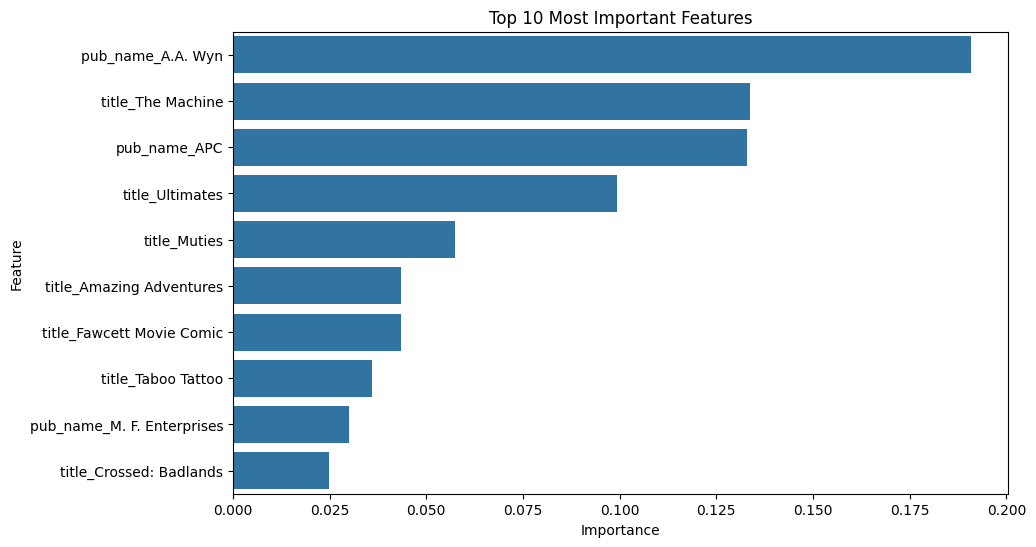

In [11]:
# Get feature importances
feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=categorical_cols)
all_feature_names = np.concatenate([feature_names, numerical_cols])
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Visualize top features
import seaborn as sns
import matplotlib.pyplot as plt
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [13]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data\data_clean.csv')

# Display the first few rows to understand the structure of the dataset
print(df.head())


   Unnamed: 0   pub_name        title  title_id  issue_nr  variant volume  \
0           0  DC Comics  'Mazing Man      4036       1.0    False      0   
1           1  DC Comics  'Mazing Man      4036      10.0    False      0   
2           2  DC Comics  'Mazing Man      4036      11.0    False      0   
3           3  DC Comics  'Mazing Man      4036      12.0    False      0   
4           4  DC Comics  'Mazing Man      4036       2.0    False      0   

   print_nr cover_date  cover_price  current_value special  searched  owned  \
0         1    Jan '86         0.75            3.0     not      1259    181   
1         1    Oct '86         0.75            3.0     not       182     70   
2         1    Nov '86         0.75            3.0     not       190     65   
3         1    Dec '86         0.75            4.0     not       670     96   
4         1    Feb '86         0.75            3.0     not       413    118   

   first_appear_event  death_event  origin_event  issues_total